In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from utils import parse_points3D, parse_cameras, parse_images, plot3D, remove_outliers, get_3D_box, gen_video
from ransac import get_inplane_point_idx, ransac
from rigid import translate, get_vector_normal, get_rotation_matrix, rotate
from projection import forward_projection, calc_depth, order_by_depth

In [2]:
points3D_txt = './home/points3D.txt'
data = parse_points3D(points3D_txt)
print(data.shape)

cameras_txt = './home/cameras.txt'
cameras = parse_cameras(cameras_txt)
print(cameras[1])

images_txt = './home/images.txt'
images = parse_images(images_txt)
# print(images)
print({k:v for k,v in images[1].items()})

(30624, 3)
{'MODEL': 'SIMPLE_RADIAL', 'WIDTH': 1920, 'HEIGHT': 1080, 'PARAMS': [1855.42, 960.0, 540.0, 0.00782192]}
{'QW': 0.995842, 'QX': -0.0167632, 'QY': -0.080855, 'QZ': -0.0384821, 'TX': 3.70913, 'TY': -1.19895, 'TZ': 1.91089, 'CAMERA_ID': 1, 'NAME': 'frame0.png'}


### Remove extreme outliers

In [3]:
data = remove_outliers(data, 4)
print(data.shape)

# outlier points: (79, 3)
# inlier points: (30545, 3)
(30545, 3)


### Run RANSAC to find dominant plane

In [4]:
sample_size = 3
num_iters = 20
threshold_inlier = 0.01
num_points = 1000
best_model, best_count = ransac(data, sample_size, num_iters, threshold_inlier, num_points)
print('best fit:', best_model, best_count)

iter 0: model param [-0.19630177 -0.13041541 -0.12267002  0.96405887], in plane point count 418
iter 1: model param [-0.00334975 -0.13607803 -0.09307215  0.98631086], in plane point count 18908
iter 2: model param [ 0.19462291  0.14981726 -0.00962225  0.96932147], in plane point count 160
iter 3: model param [-0.00415991 -0.01231827 -0.12418327  0.99217411], in plane point count 1619
iter 4: model param [-0.37415369 -0.69513662 -0.14828412  0.59565587], in plane point count 69
iter 5: model param [ 0.08515585 -0.10293065 -0.09584091  0.98639155], in plane point count 1221
iter 6: model param [ 0.14455777 -0.08494849 -0.09470114  0.98128411], in plane point count 655
iter 7: model param [ 0.17956892  0.02547921 -0.13245477  0.97445449], in plane point count 902
iter 8: model param [-0.00334302 -0.13768942 -0.09296484  0.98609735], in plane point count 18572
iter 9: model param [ 0.04761141 -0.09232996 -0.108969    0.98860209], in plane point count 1884
iter 10: model param [-0.00159972 

In [5]:
inplane_point_idx = get_inplane_point_idx(best_model, data, threshold_inlier)
inplane_points = data[inplane_point_idx, :]
print('# inplane points:', inplane_points.shape)

mask = np.ones(len(data), np.bool)
mask[inplane_point_idx] = 0
outplane_points = data[mask]
print('# outplane points:', outplane_points.shape)

# inplane points: (18959, 3)
# outplane points: (11586, 3)


### XYZ coordinates

<IPython.core.display.Javascript object>


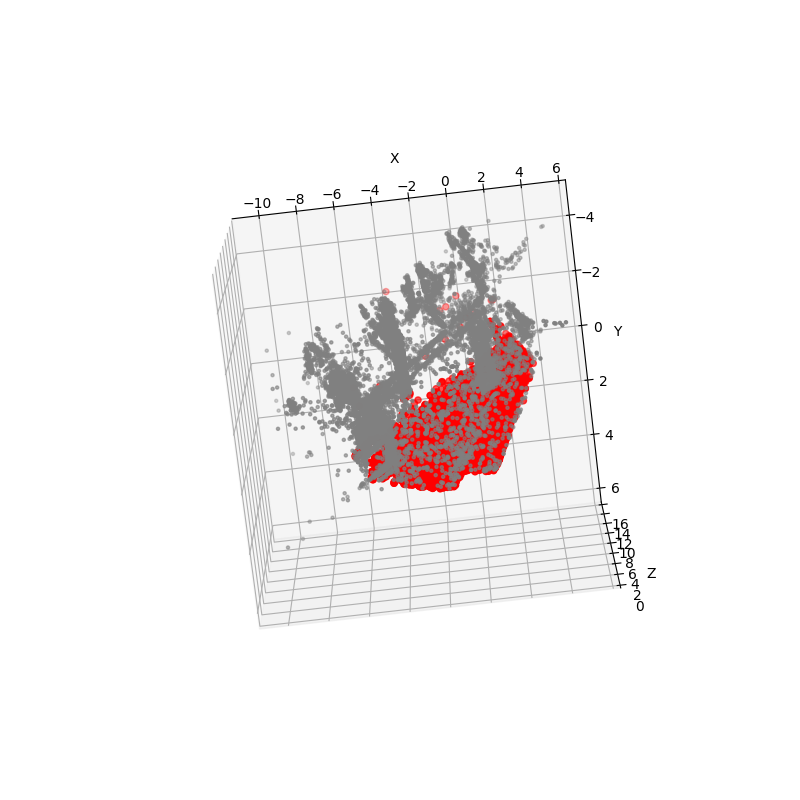

In [6]:
%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_plane=False)

<IPython.core.display.Javascript object>


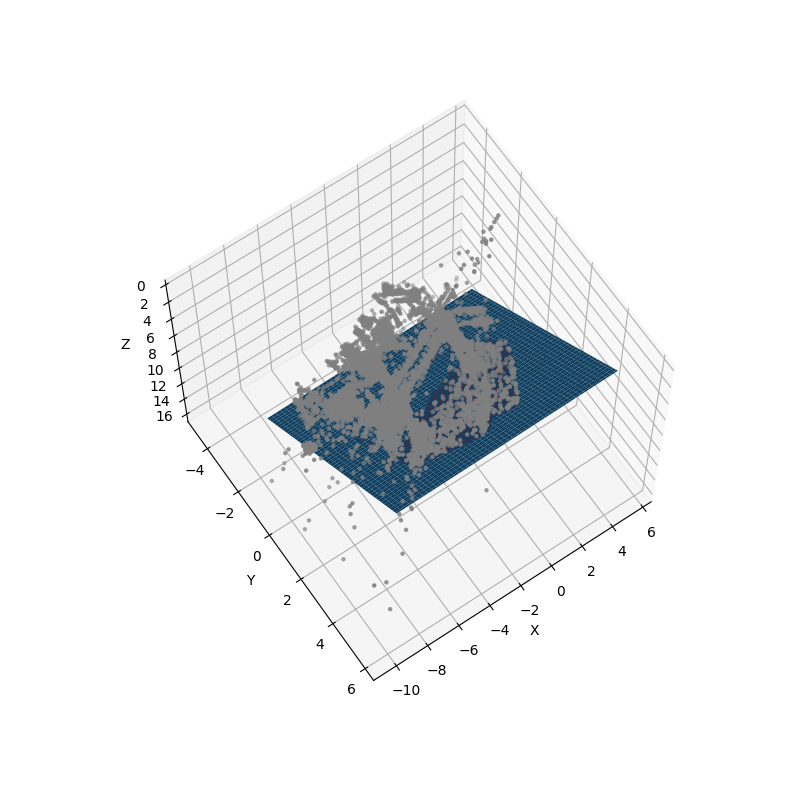

In [7]:
%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_plane=True, model=best_model)

### Compute rotation matrix

In [8]:
center_XYZ = np.mean(inplane_points, axis=0)
center_XYZ = center_XYZ.reshape(1, 3)
inplane_points_centered = translate(inplane_points, -center_XYZ)
outplane_points_centered = translate(outplane_points, -center_XYZ)

In [9]:
normal_XYZ = get_vector_normal(best_model)
normal_xyz = np.array([0, 0, 1])

In [10]:
# R_xyz2XYZ = get_rotation_matrix(normal_xyz, normal_XYZ)
R_XYZ2xyz = get_rotation_matrix(normal_XYZ, normal_xyz)

In [11]:
inplane_points_local = rotate(inplane_points_centered, R_XYZ2xyz)
outplane_points_local = rotate(outplane_points_centered, R_XYZ2xyz)

### Local xyz coordinates

<IPython.core.display.Javascript object>


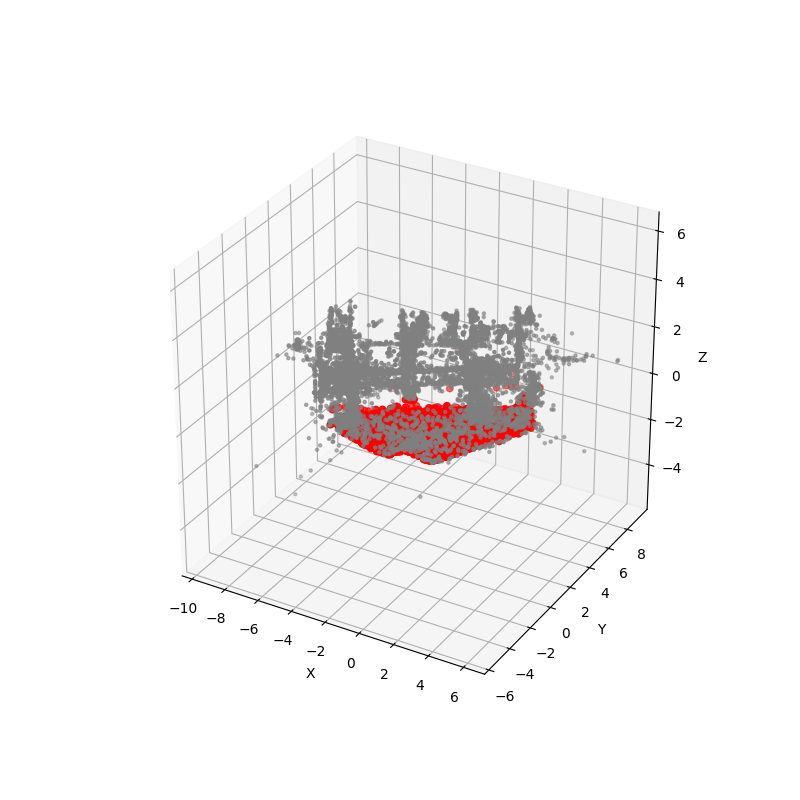

In [12]:
%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_plane=False)

<IPython.core.display.Javascript object>


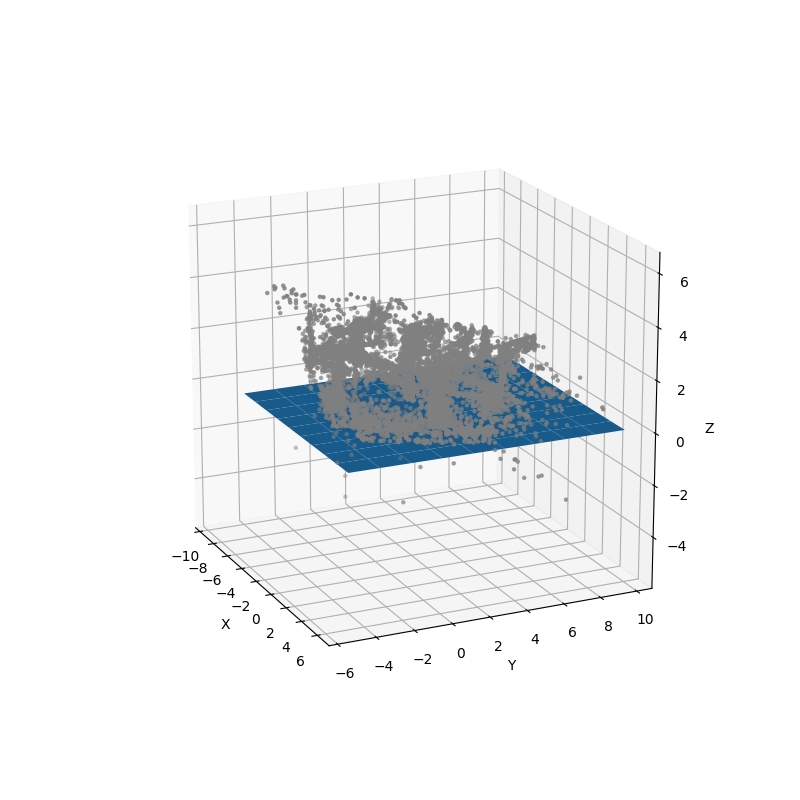

In [29]:
%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_plane=True, model=np.array([0, 0, 1, 0]))

### Put a 3D box in local xyz coordinates

In [18]:
dimx, dimy, dimz = 2, 2, 1 # box dimension along axis
corners_local = get_3D_box(dimx, dimy, dimz)

In [28]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def add_plane(ax, model, x, y):
    a, b, c, d = model
    xmin, xmax = np.min(x), np.max(x)
    xlen = xmax - xmin
    xmin -= xlen * 0.2
    xmax += xlen * 0.2
    ymin, ymax = np.min(y), np.max(y)
    ylen = ymax - ymin
    ymin -= ylen * 0.2
    ymax += ylen * 0.2
    X = np.linspace(xmin, xmax, 10)
    Y = np.linspace(ymin, ymax, 10)
    X, Y = np.meshgrid(X, Y)
    Z = -(a*X + b*Y + d) / c
    ax.plot_surface(X, Y, Z)

def add_box(ax, corners):
    combinations = [[0,1,2,3],  # bottom
                    [4,5,6,7],  # top
                    [0,1,5,4],  # right
                    [3,2,6,7],  # left
                    [0,4,7,3],  # front
                    [1,5,6,2]]  # back
    combinations = np.array(combinations)
    for comb in combinations:
        vertices = corners[comb, :]
        ax.add_collection3d(Poly3DCollection([vertices]))
    # ax.scatter3D(corners[:, 0], corners[:, 1], corners[:, 2], color='blue')

def plot3D(inplane_points, outplane_points, plot_plane=False, model=None, plot_box=False, corners=None):
    fig = plt.figure(1, figsize=(8, 8))
    ax = fig.gca(projection='3d')

    # plot outplane points
    xo = outplane_points[:, 0]
    yo = outplane_points[:, 1]
    zo = outplane_points[:, 2]
    ax.scatter(xo, yo, zo, marker='.', color='gray')

    # plot inplane points
    xi = inplane_points[:, 0]
    yi = inplane_points[:, 1]
    zi = inplane_points[:, 2]
    zi=np.expand_dims(zi,axis=1)
    ax.scatter(xi, yi, zi, marker='o', color='red')

    # plot the surface
    if plot_plane:
        add_plane(ax, model, xi, yi)
        
    # plot the box
    if plot_box:
        add_box(ax, corners)
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

<IPython.core.display.Javascript object>


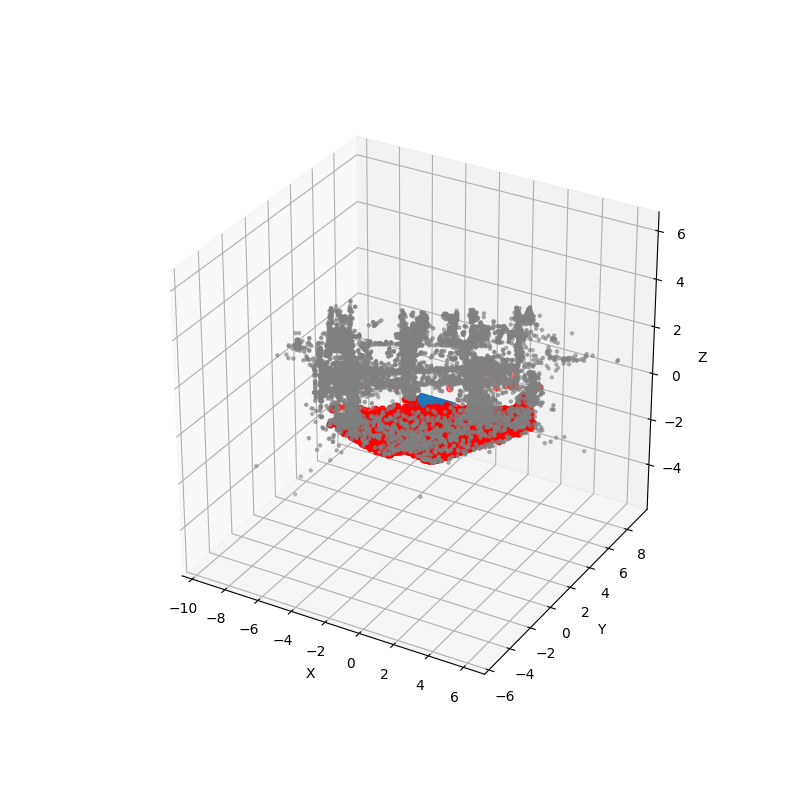

In [26]:
%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_box=True, corners=corners_local)

### Convert local 3D box back to scene XYZ coordinates

In [16]:
R_xyz2XYZ = get_rotation_matrix(normal_xyz, normal_XYZ)
corners = rotate(corners_local, R_xyz2XYZ)
corners = translate(corners, center_XYZ)
corners

array([[ 0.17248138,  1.3035384 ,  8.69019582],
       [-1.82613564,  1.36935194,  8.65557495],
       [-1.76032209,  2.50128942,  7.00803553],
       [ 0.23829492,  2.43547587,  7.04265641],
       [ 0.15517094,  0.47976869,  8.1235356 ],
       [-1.84344607,  0.54558223,  8.08891472],
       [-1.77763253,  1.67751971,  6.44137531],
       [ 0.22098449,  1.61170616,  6.47599618]])

<IPython.core.display.Javascript object>


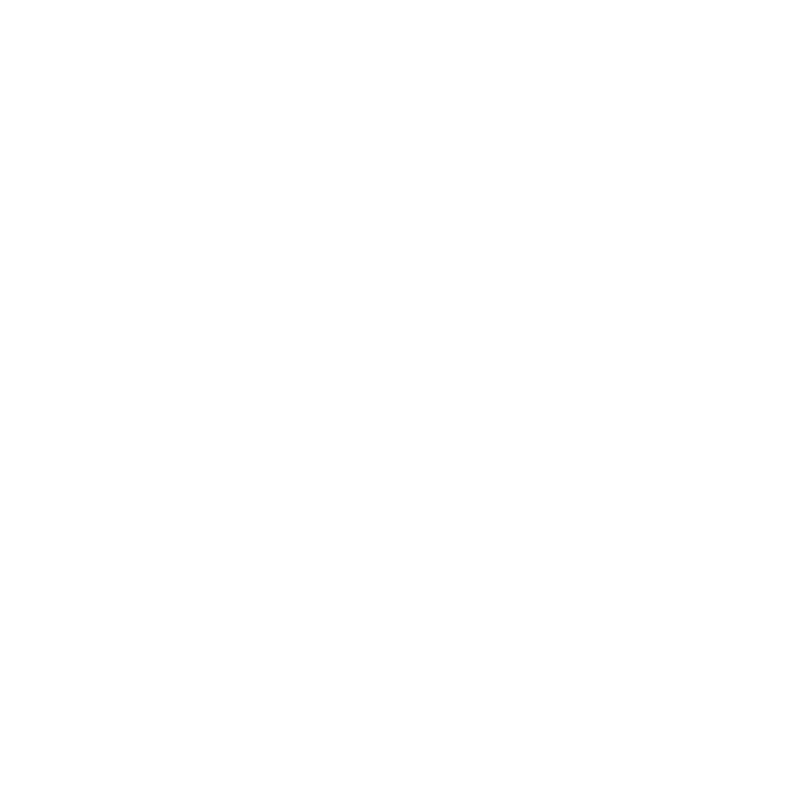

In [17]:
%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_box=True, corners=corners)

### Check world -> image projection

In [18]:
# use 1st camera model and pose of 1st image
uv, _ = forward_projection(data, cameras[1], images[1])
# remove key points outside of image plane
WIDTH = cameras[1]['WIDTH']
HEIGHT = cameras[1]['HEIGHT']
uv_trimmed = []
for u, v in uv:
    if 0 <= u < WIDTH and 0 <= v < HEIGHT:
        uv_trimmed.append([u, v])
uv_trimmed = np.array(uv_trimmed)

<IPython.core.display.Javascript object>


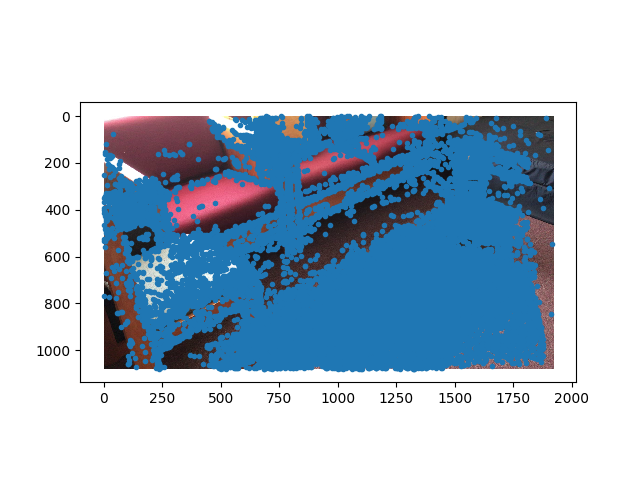

In [20]:
img = cv2.imread('./home/frames/frame0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.scatter(uv_trimmed[:, 0], uv_trimmed[:, 1], marker='.')
plt.show()

## Put virtual box on image

In [21]:
num_imgs = len(images)
i = 1 # index starts from 1
uv, depths = forward_projection(corners, cameras[1], images[i], calc_depth)
uv

array([[1419,  616],
       [1077,  658],
       [1191,  912],
       [1593,  853],
       [1446,  463],
       [1085,  501],
       [1209,  741],
       [1636,  685]])

<IPython.core.display.Javascript object>


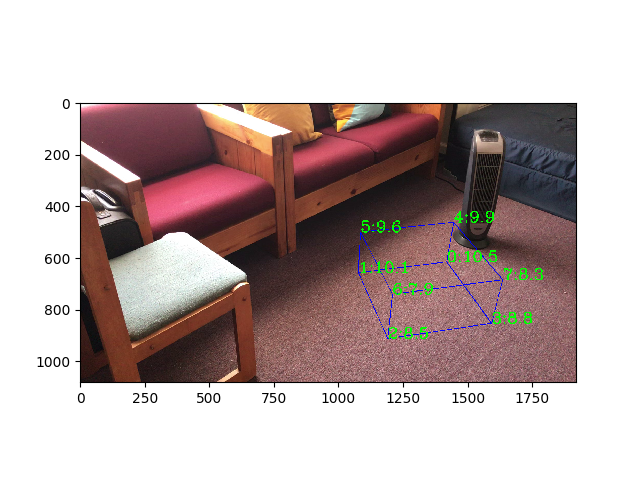

In [22]:
img = cv2.imread('./home/frames/frame0.png')
combinations = [[0,1,2,3],  # bottom
                [4,5,6,7],  # top
                [0,1,5,4],  # right
                [3,2,6,7],  # left
                [0,4,7,3],  # front
                [1,5,6,2]]  # back
combinations = np.array(combinations)
for comb in combinations:
    vertices = uv[comb, :]
    p1, p2, p3, p4 = vertices
    cv2.line(img, tuple(p1), tuple(p2), (255,0,0), 2)
    cv2.line(img, tuple(p2), tuple(p3), (255,0,0), 2)
    cv2.line(img, tuple(p3), tuple(p4), (255,0,0), 2)
    cv2.line(img, tuple(p4), tuple(p1), (255,0,0), 2)
for i in range(8):
    u, v = uv[i]
    d = depths[i]
    cv2.putText(img,'{}:{:.1f}'.format(i,d),(u,v),cv2.FONT_HERSHEY_COMPLEX,2,(0,255,0),3)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

#### plot surfaces ordered by depth

[[0 1 5 4]
 [0 1 2 3]
 [0 4 7 3]
 [4 5 6 7]
 [3 2 6 7]
 [1 5 6 2]]


<IPython.core.display.Javascript object>


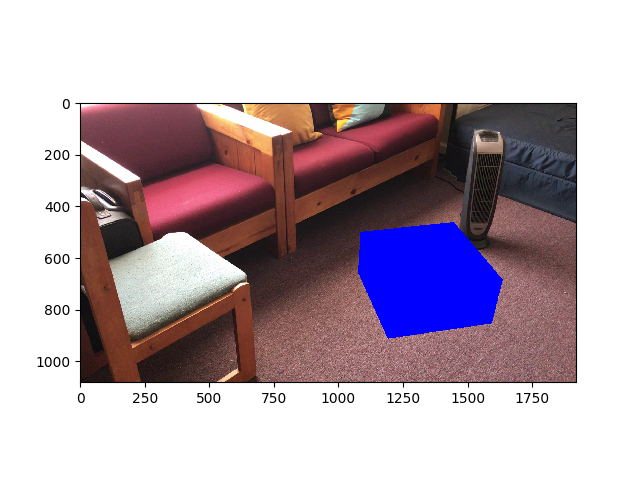

In [23]:
img = cv2.imread('./home/frames/frame0.png')
new_combinations = order_by_depth(combinations, depths)
print(new_combinations)
for comb in new_combinations:
    vertices = uv[comb, :]
    cv2.fillPoly(img, [vertices], color=(255,0,0))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

### Process all images and generate a video

In [24]:
frame_dir = './home/frames'
result_dir = './home/framesaug'
os.makedirs(result_dir, exist_ok=True)

num_imgs = len(images)
for i in range(1, num_imgs+1):
    uv, depths = forward_projection(corners, cameras[1], images[i], calc_depth)
    name = images[i]['NAME']
    name_ori = os.path.join(frame_dir, name)
    
    img = cv2.imread(name_ori)
    new_combinations = order_by_depth(combinations, depths)
    for comb in new_combinations:
        vertices = uv[comb, :]
        cv2.fillPoly(img, [vertices], color=(255,0,0))
    
    name_aug = os.path.join(result_dir, name)
    cv2.imwrite(name_aug, img)

In [25]:
video_name = './home/homeaug.mov'
gen_video(result_dir, video_name)